# Packages

In [2]:
pip install mplsoccer


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import json
import time
from pathlib import Path
from datetime import datetime
import ast
import math

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Loading Data

In [4]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

In [5]:
football = pd.read_csv(RAW_DIR / "football_copy.csv")

In [6]:
football.head(3)

,id,index,match_id,period,timestamp,second,minute,team,team_id,player,...,shot_open_goal,shot_type,shot_statsbomb_xg,shot_freeze_frame,location,shot_outcome,shot_body_part,shot_first_time,shot_technique,shot_one_on_one
0,ba46e9d6-e828-4599-952c-39c1f7d22659,263,3890561,1,00:04:21.052,21,4,Hoffenheim,175,Tarik Elyounoussi,...,NaN,Open Play,0.087901,"[{'location': [115.7, 50.0], 'player': {'id': ...","[108.1, 31.2]",Off T,Left Foot,True,Half Volley,NaN
1,85d67225-30fb-47c8-b478-cf568941a164,353,3890561,1,00:06:27.395,27,6,Schalke 04,181,Klaas-Jan Huntelaar,...,NaN,Open Play,0.160274,"[{'location': [98.4, 33.1], 'player': {'id': 8...","[110.9, 42.6]",Goal,Right Foot,True,Volley,NaN
2,adac17d3-5e67-4e8c-b482-4bae2f36e06e,410,3890561,1,00:08:16.762,16,8,Hoffenheim,175,Kevin Volland,...,NaN,Open Play,0.016036,"[{'location': [101.9, 52.4], 'player': {'id': ...","[117.9, 29.1]",Blocked,Left Foot,True,Half Volley,NaN


# EDA

In [7]:
def visualize_dist(col, tilt_labels:bool = False):

    counts = football[col].value_counts()

    fig, ax = plt.subplots(figsize= (10,3))
    bars = ax.bar(counts.index, counts)
    ax.bar_label(bars)
    ax.set_ylim(0, max(counts)*1.1)
    ax.set_ylabel("Count")
    ax.set_title(f"Distribution of {col}")
    if tilt_labels:
        ax.set_xticklabels(counts.index, rotation=45, ha='right')
    plt.show()

Looking at available columns

In [8]:
football.columns

Index(['id', 'index', 'match_id', 'period', 'timestamp', 'second', 'minute',
       'team', 'team_id', 'player', 'player_id', 'position', 'play_pattern',
       'type', 'under_pressure', 'shot_deflected', 'shot_open_goal',
       'shot_type', 'shot_statsbomb_xg', 'shot_freeze_frame', 'location',
       'shot_outcome', 'shot_body_part', 'shot_first_time', 'shot_technique',
       'shot_one_on_one'],
      dtype='object')

## Background info

ID column looks good. 45220 Unique values for 45220 rows. No missing values.

In [9]:
football["id"].describe()

count                                    45719
unique                                   45719
top       ba46e9d6-e828-4599-952c-39c1f7d22659
freq                                         1
Name: id, dtype: object

## Event Data

Small number of penalties and even smaller number of corner which were attempted as shots. We will remove them because there are only 13 corner shots and penalties are a different type of event altogether.

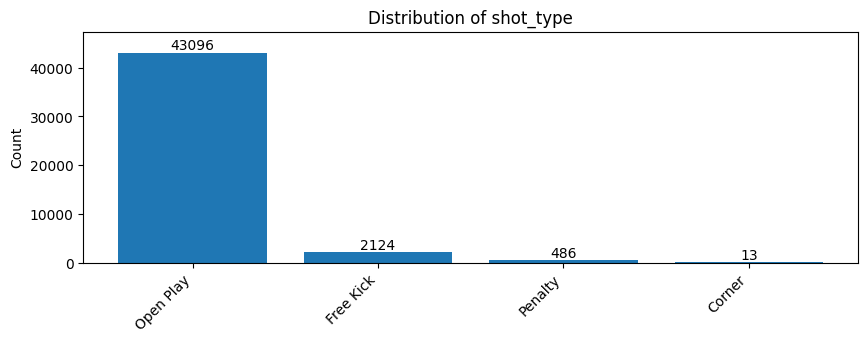

In [10]:
visualize_dist("shot_type", True)

Variety of play patterns with "from keeper", "other", and "from kick off" occuring less frequently. Number of occurences seem high enough to keep all categories for now.

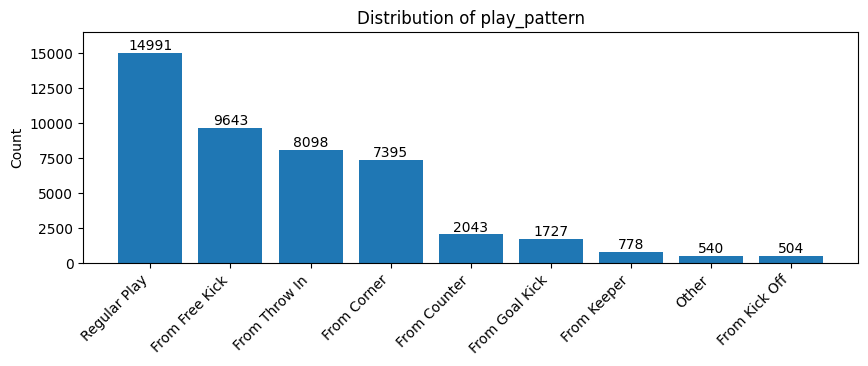

In [11]:
visualize_dist("play_pattern", True)

Will need to combine right and left foot into one variable since we do not know, if a players left or right foot is stronger. Since there are more right footed players it could happen that left foot becomes less significant in the model because right footed are less efficient with their left foot. We would need to add information about their strong foot to use both variables.

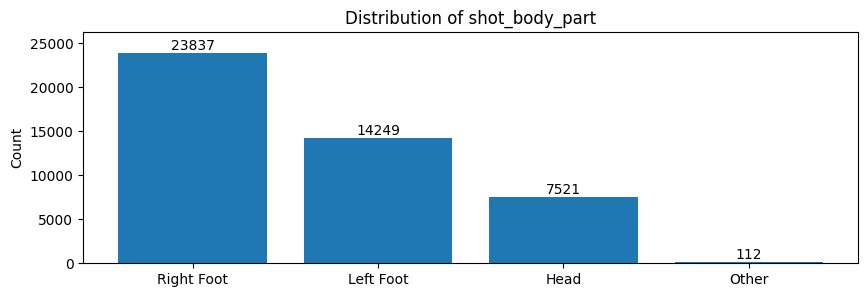

In [12]:
visualize_dist("shot_body_part")

Will need to transform shot outcome into binary variable for modeling. 1 for goal, 0 for no goal.

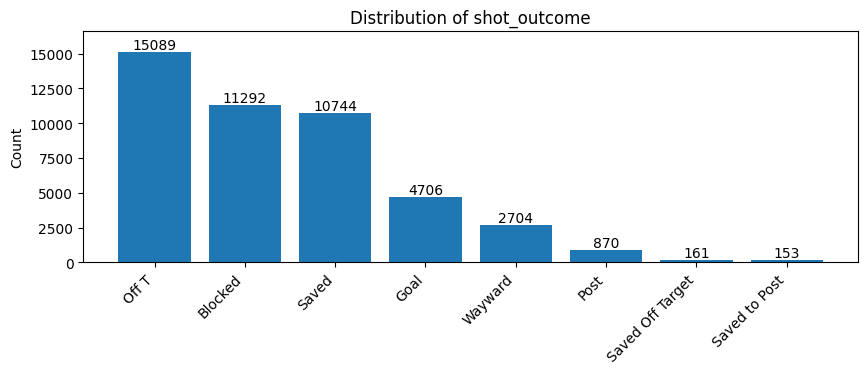

In [13]:
visualize_dist("shot_outcome", True)

Shot technique provides interesting details how shot was taken. There are 3 categories (overhead kick, backheel and diving header) which are less frequent. We still keep them as they might provide useful information for the model since they are harder to execute.

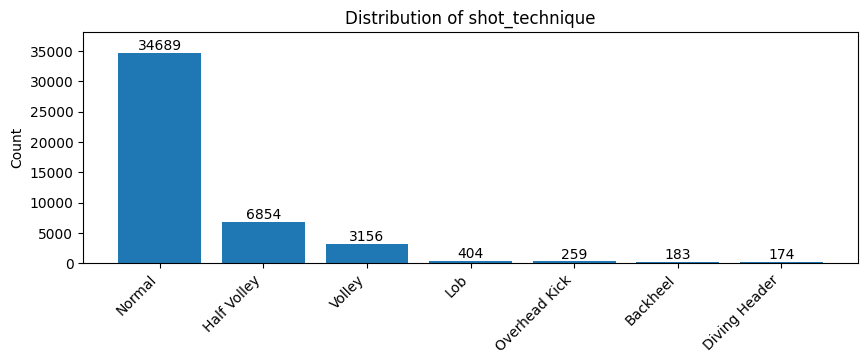

In [14]:
visualize_dist("shot_technique", True)

## Other

There appear to be missing values for:
- under pressure
- shot deflected
- shot open goal
- shot freeze frame
- shot first time
- shot technique
- shot one on one

Upon inspection of the data documentation it appears like this is the way it is being recorded in statsbombs systems. They only capture True values and leave the rest blank (NaN). Therefore we will impute missing values with False for these boolean columns.

In [15]:
football[['play_pattern', 'type', 'under_pressure', 'shot_deflected', 'shot_open_goal',
       'shot_type', 'shot_statsbomb_xg', 'shot_freeze_frame', 'location',
       'shot_outcome', 'shot_body_part', 'shot_first_time', 'shot_technique',
       'shot_one_on_one']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45719 entries, 0 to 45718
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   play_pattern       45719 non-null  object 
 1   type               45719 non-null  object 
 2   under_pressure     12290 non-null  object 
 3   shot_deflected     628 non-null    object 
 4   shot_open_goal     484 non-null    object 
 5   shot_type          45719 non-null  object 
 6   shot_statsbomb_xg  45719 non-null  float64
 7   shot_freeze_frame  45285 non-null  object 
 8   location           45719 non-null  object 
 9   shot_outcome       45719 non-null  object 
 10  shot_body_part     45719 non-null  object 
 11  shot_first_time    14402 non-null  object 
 12  shot_technique     45719 non-null  object 
 13  shot_one_on_one    2332 non-null   object 
dtypes: float64(1), object(13)
memory usage: 4.9+ MB


There is no shot_freeze_frame for penalty kicks. This is another reason why we should remove penalty kicks from the dataset.

In [16]:
football[football["shot_freeze_frame"].isna()]["shot_type"].value_counts()

shot_type
Penalty    434
Name: count, dtype: int64

## Data format

Bcs we exported the data as a csv file some columns have wrong data types. We will need to convert them before modeling.

In [17]:
type(football["shot_freeze_frame"][0]), type(football["location"][0])

(str, str)

Both should be lists but instead both are strings right now.

In [18]:
football["location"][0], football["shot_freeze_frame"][0]

('[108.1, 31.2]',
 "[{'location': [115.7, 50.0], 'player': {'id': 3510, 'name': 'Sead Kolašinac'}, 'position': {'id': 6, 'name': 'Left Back'}, 'teammate': False}, {'location': [113.2, 39.3], 'player': {'id': 3502, 'name': 'Joël Andre Job Matip'}, 'position': {'id': 3, 'name': 'Right Center Back'}, 'teammate': False}, {'location': [119.0, 42.5], 'player': {'id': 16534, 'name': 'Roman Neustädter'}, 'position': {'id': 5, 'name': 'Left Center Back'}, 'teammate': False}, {'location': [111.6, 34.8], 'player': {'id': 7016, 'name': 'Benedikt Höwedes'}, 'position': {'id': 2, 'name': 'Right Back'}, 'teammate': False}, {'location': [96.7, 36.3], 'player': {'id': 6039, 'name': 'Sebastian Rudy'}, 'position': {'id': 11, 'name': 'Left Defensive Midfield'}, 'teammate': True}, {'location': [104.0, 43.8], 'player': {'id': 8556, 'name': 'Pirmin Schwegler'}, 'position': {'id': 9, 'name': 'Right Defensive Midfield'}, 'teammate': True}, {'location': [109.2, 37.7], 'player': {'id': 5460, 'name': 'Andrej Kram

# Aggregations

In [19]:
def annotate_graph(name: str, x, y, off_x, off_y):
    plt.annotate(
        text = name, 
        xy = (x, y),
        xytext=(off_x, off_y),          
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="black")
    )

5 teams with the most shots

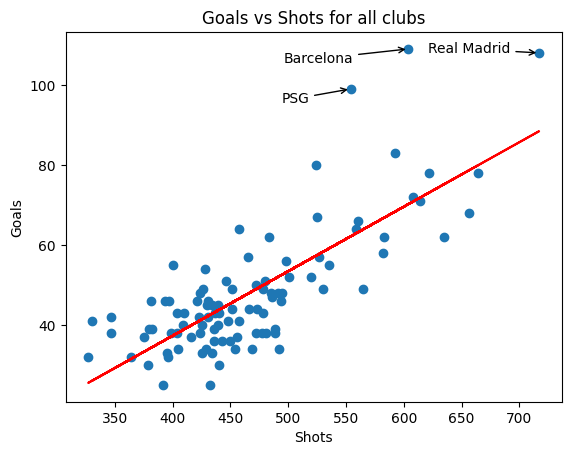

In [20]:
team_stats = football.assign(
    Goal=lambda d: (d.shot_outcome == "Goal").astype(int),
    Total = 1
).pivot_table(
    index="team",
    values=["Goal", "Total"],
    aggfunc="sum"
)

plt.scatter(y = team_stats["Goal"], x = team_stats["Total"])
x = team_stats["Goal"].values
y = team_stats["Total"].values
slope, intercept = np.polyfit(y, x, 1)
plt.plot(y, slope*y + intercept, color = "red")

# annotate graph
annotate_graph("Barcelona", 604, 109, -90, -10)
annotate_graph("Real Madrid", 717, 108, -80, 0)
annotate_graph("PSG", 554, 99, -50, -10)

plt.title("Goals vs Shots for all clubs")
plt.xlabel("Shots")
plt.ylabel("Goals")
plt.show()


5 top scorers

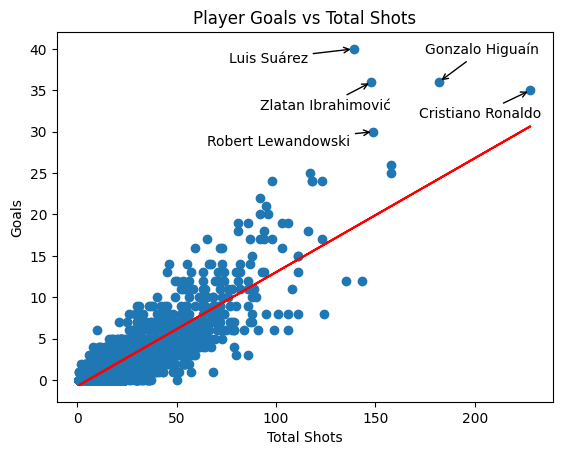

In [21]:
player_stats = football.assign(
    Goal=lambda d: (d.shot_outcome == "Goal").astype(int),
    Total=1
).pivot_table(
    index="player",
    values=["Goal", "Total"],
    aggfunc="sum"
)

plt.scatter(y = player_stats["Goal"], x = player_stats["Total"])
x_p = player_stats["Goal"].values
y_p = player_stats["Total"].values

slope, intercept = np.polyfit(y_p, x_p, 1)
plt.plot(y_p, slope * y_p + intercept, color = "red")

# annotate graph
annotate_graph("Luis Suárez", 139, 40, -90, -10)
annotate_graph("Zlatan Ibrahimović", 148, 36, -80, -20)
annotate_graph("Cristiano Ronaldo", 228, 35, -80, -20)
annotate_graph("Gonzalo Higuaín", 182, 36, -10, 20)
annotate_graph("Robert Lewandowski", 149, 30, -120, -10)

plt.xlabel("Total Shots")
plt.ylabel("Goals")
plt.title("Player Goals vs Total Shots")
plt.show()

In [22]:
player_stats.sort_values("Goal", ascending=False).head(10)

,Goal,Total
player,,
Luis Alberto Suárez Díaz,40,139
Zlatan Ibrahimović,36,148
Gonzalo Gerardo Higuaín,36,182
Cristiano Ronaldo dos Santos Aveiro,35,228
Robert Lewandowski,30,149
Lionel Andrés Messi Cuccittini,26,158
Harry Kane,25,158
Pierre-Emerick Aubameyang,25,117
Sergio Leonel Agüero del Castillo,24,118


# Skill vs luck

In [23]:
def get_stats(df):
    df_new = df.assign(
        Goal = lambda x: (x["shot_outcome"] == "Goal").astype(int),
        Total = 1
    ).pivot_table(
        index = "team",
        values = ["Goal", "Total"],
        aggfunc = sum
    )

    return df_new

0.6878774793770788


/var/folders/_d/ljvnpndd76v52vr16dysc7lr0000gn/T/ipykernel_22600/2353899193.py:5: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).pivot_table(
/var/folders/_d/ljvnpndd76v52vr16dysc7lr0000gn/T/ipykernel_22600/2353899193.py:5: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).pivot_table(


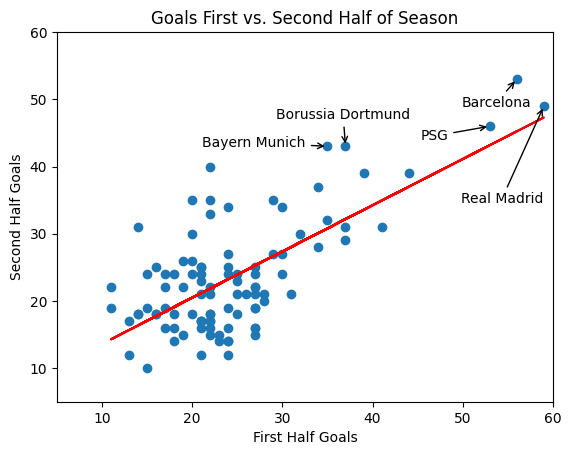

In [24]:
# first_half = football[:round(len(football)/2)]
# second_half = football[round(len(football)/2):]

first_half = football[football.groupby('team').cumcount() < football.groupby('team')['team'].transform('count')/2]
second_half = football[football.groupby('team').cumcount() >= football.groupby('team')['team'].transform('count')/2]


first_half_stats = get_stats(first_half)
second_half_stats = get_stats(second_half)

combined_stats = pd.concat([first_half_stats, second_half_stats], axis = 1)
combined_stats.columns = ["Goal1", "Total1", "Goal2", "Total2"]
plt.scatter(combined_stats["Goal1"], combined_stats["Goal2"])
plt.xlabel("First Half Goals")
plt.ylabel("Second Half Goals")

x_skill = combined_stats["Goal1"].values
y_skill = combined_stats["Goal2"].values

slope, intercept = np.polyfit(x_skill, y_skill, 1)

plt.plot(x_skill, slope * x_skill + intercept, color = "red")
plt.xlim(5,60)
plt.ylim(5,60)
annotate_graph("Real Madrid", 59, 49, -60, -70)
annotate_graph("Barcelona", 56, 53, -40, -20)
annotate_graph("PSG", 53, 46, -50, -10)
annotate_graph("Bayern Munich", 35, 43, -90, 0)
annotate_graph("Borussia Dortmund", 37, 43, -50, 20)
plt.title("Goals First vs. Second Half of Season")
print(slope)

# Goal Distribution

In [35]:
football.columns

Index(['id', 'index', 'match_id', 'period', 'timestamp', 'second', 'minute',
       'team', 'team_id', 'player', 'player_id', 'position', 'play_pattern',
       'type', 'under_pressure', 'shot_deflected', 'shot_open_goal',
       'shot_type', 'shot_statsbomb_xg', 'shot_freeze_frame', 'location',
       'shot_outcome', 'shot_body_part', 'shot_first_time', 'shot_technique',
       'shot_one_on_one'],
      dtype='object')

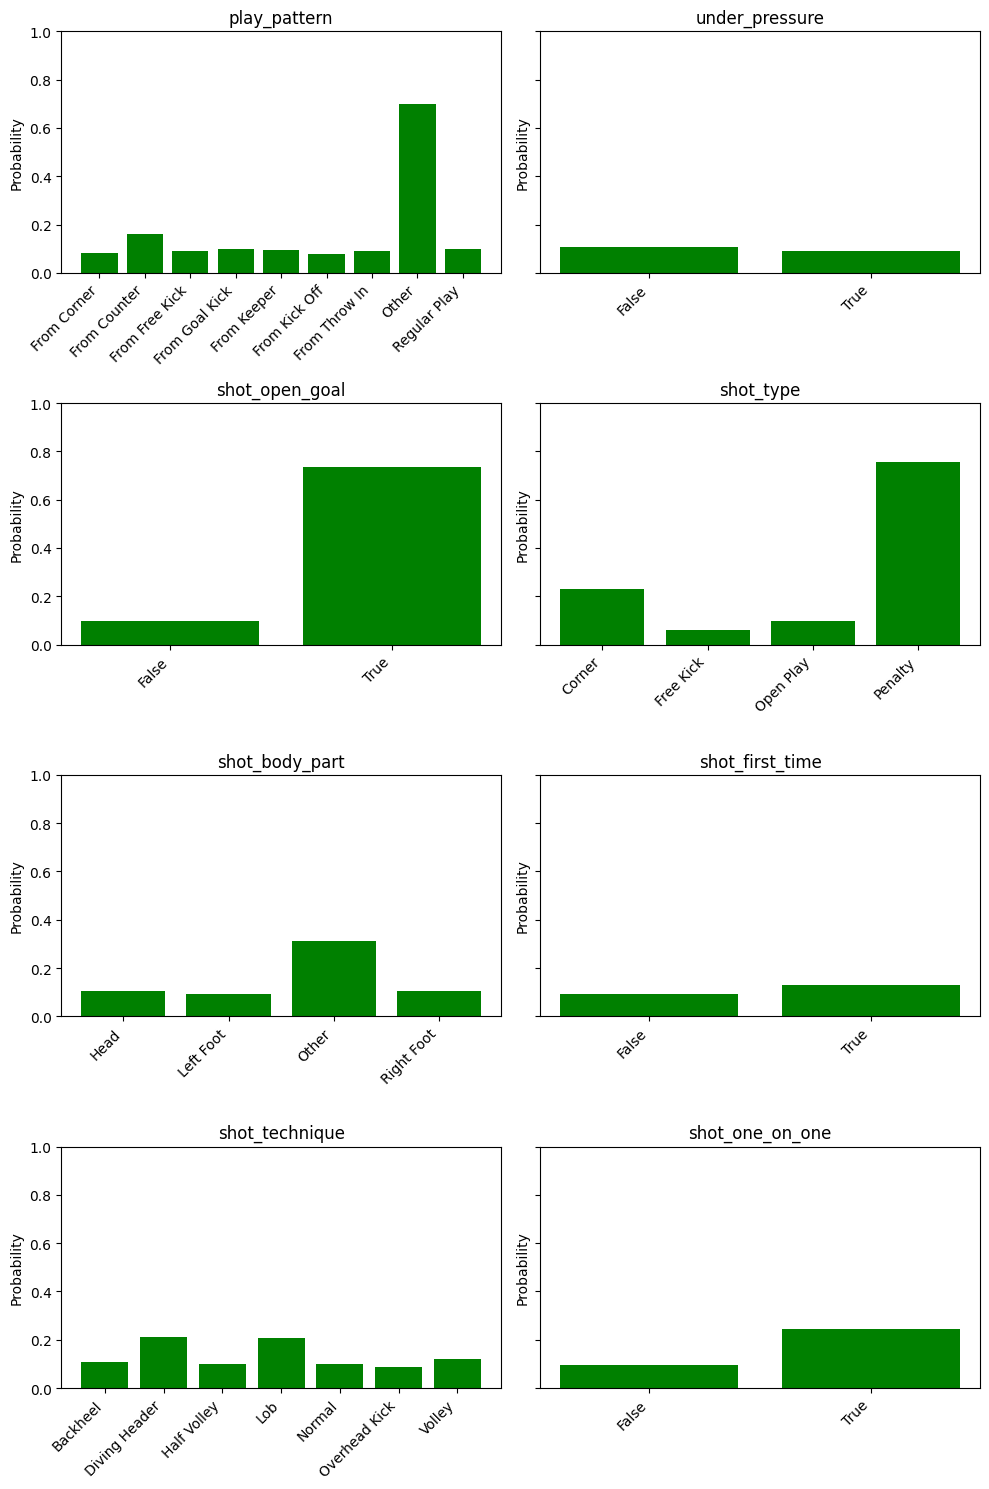

In [ ]:
# filling NAs according to the documentation so we can visualize their distributions
football_copy = football.fillna(False)

# selecting relevant columns for visualization
relevant_columns = ["play_pattern", "under_pressure", 
                    "shot_open_goal", "shot_type", 
                    "shot_body_part", "shot_first_time", 
                    "shot_technique", "shot_one_on_one"]

fig, axes = plt.subplots(4,2, figsize=(10, 15), sharey=True)
axes_flat = axes.flatten()

# generating plots, used subplots to show them together easily
for i, col in enumerate(relevant_columns):
    result = football_copy.groupby([col, football["shot_outcome"] == "Goal"])["shot_type"].count().unstack()
    if result.index[0] == 0:
        result.index = ["False", "True"]
    result["ratio_goals"] = result.iloc[:,1] / (result.iloc[:,0] + result.iloc[:,1])
    axes_flat[i].bar(x = result.index, height = result["ratio_goals"], label = "Ratio Goals", color = "green")
    axes_flat[i].set_title(col)
    axes_flat[i].set_ylabel("Probability")
    axes_flat[i].set_ylim(0,1)
    axes_flat[i].set_xticklabels(result.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Visualizations

Testing if our process location function works correctly by plotting shot locations on a soccer field.

In [ ]:
def process_location(df, type, col):
    df[[f"{type}_x", f"{type}_y"]] = pd.DataFrame(df[col].tolist(), index=df.index)
    return df

In [ ]:
football["location"] = football['location'].apply(ast.literal_eval)
football = process_location(football, "player", "location")

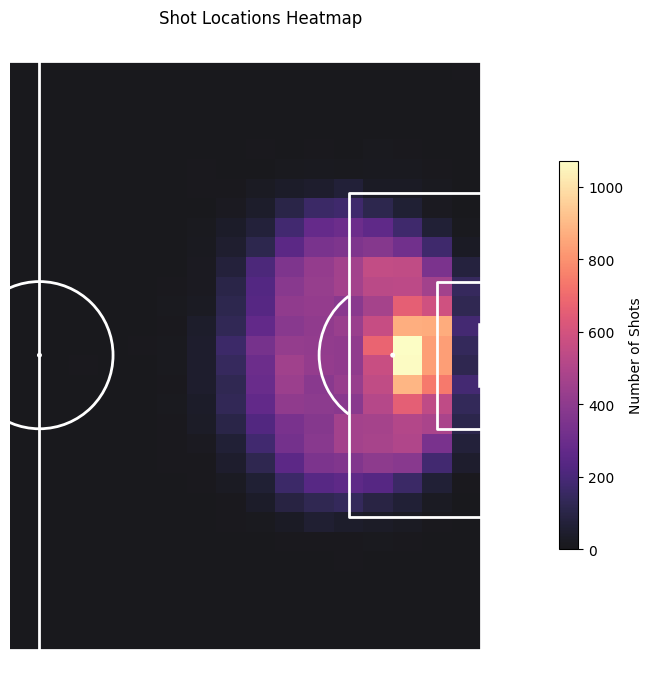

In [ ]:
no_penalties = football[football["shot_type"] != "Penalty"].copy()
pitch = Pitch(pitch_type='statsbomb', line_color='white', line_zorder=2, half=True, pitch_color='white')
fig, ax = pitch.draw(figsize=(10, 7))
bin_stats = pitch.bin_statistic(no_penalties['player_x'], no_penalties['player_y'], statistic='count', bins=(30, 30))
heatmap = pitch.heatmap(bin_stats, ax=ax, cmap='magma', edgecolors='none', alpha=0.9)
cbar = fig.colorbar(heatmap, ax=ax, shrink=0.6)
cbar.set_label('Number of Shots')
plt.title('Shot Locations Heatmap')
plt.show()

In [ ]:
football["shot_type"].value_counts()

shot_type
Open Play    43096
Free Kick     2124
Penalty        486
Corner          13
Name: count, dtype: int64